In [1]:
import jax
import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions

from jaxns.framework.model import Model
from jaxns.framework.prior import Prior


def prior_model():
    mu = yield Prior(tfpd.Normal(loc=0., scale=1.))
    # Let's make sigma a parameterised variable. 
    # It requires a name, but will not be collected as a Bayesian variable.
    sigma = yield Prior(tfpd.Exponential(rate=1.), name='sigma').parametrised()
    x = yield Prior(tfpd.Cauchy(loc=mu, scale=sigma), name='x')
    uncert = yield Prior(tfpd.Exponential(rate=1.), name='uncert')
    return x, uncert


def log_likelihood(x, uncert):
    return tfpd.Normal(loc=0., scale=uncert).log_prob(x)


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

# You can sanity check the model (always a good idea when exploring)
model.sanity_check(key=jax.random.PRNGKey(0), S=100)

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:15: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [2]:
# Sample the prior in U-space (base measure)
U = model.sample_U(key=jax.random.PRNGKey(0))
# Transform to X-space
X = model.transform(U=U)
# Only named Bayesian prior variables are returned, the rest are treated as hidden variables.
assert set(X.keys()) == {'x', 'uncert'}

# Get the return value of the prior model, i.e. the input to the likelihood
x_sample, uncert_sample = model.prepare_input(U=U)

In [3]:
# Evaluate different parts of the model
log_prob_prior = model.log_prob_prior(U)
log_prob_likelihood = model.log_prob_likelihood(U, allow_nan=False)
log_prob_joint = model.log_prob_joint(U, allow_nan=False)

In [4]:
init_params = model.params


def log_prob_joint_fn(params, U):
    # Calling model with params returns a new model with the params set
    return model(params).log_prob_joint(U, allow_nan=False)


value, grad = jax.value_and_grad(log_prob_joint_fn)(init_params, U)
print(value, grad)

-11727.896588077794 {'sigma_param': Array(-29810.6208687, dtype=float64)}


In [5]:
from jaxns import NestedSampler

ns = NestedSampler(model=model, max_samples=1e5)

# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42))
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 186995
samples: 2025
phantom samples: 0
likelihood evals / sample: 92.3
phantom fraction (%): 0.0%
--------
logZ=-1.7 +- 0.12
max(logL)=14.86
H=-0.98
ESS=152
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.91 +- 0.65 | 0.13 / 0.77 / 1.87 | 0.0 | 0.0
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: -0.09 +- 0.8 | -0.99 / -0.1 / 0.72 | -0.0 | -0.0
--------


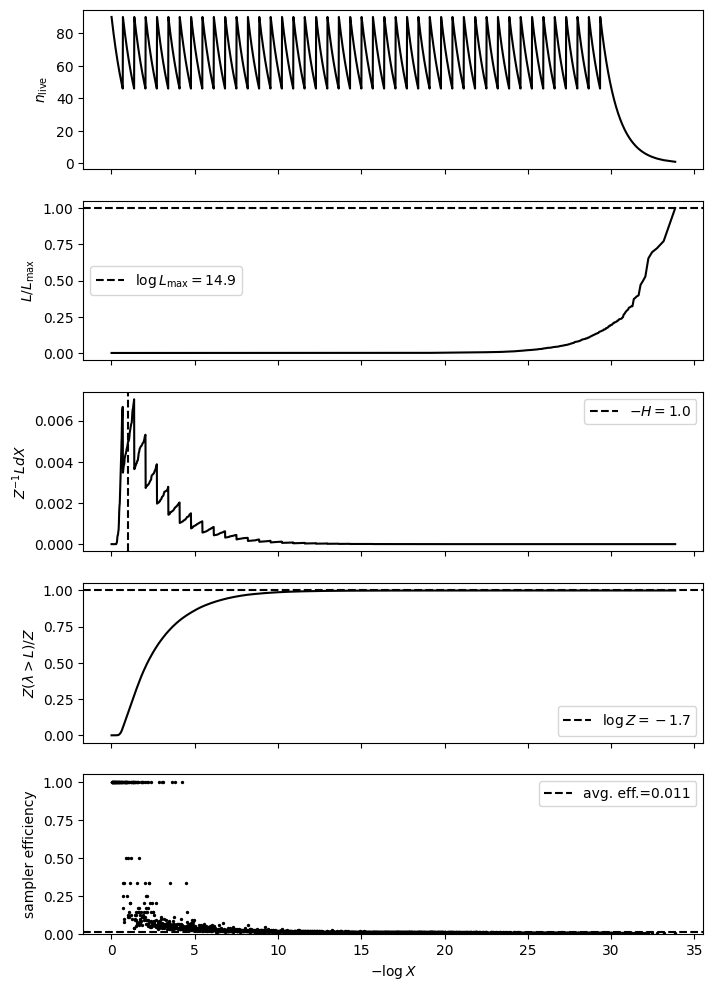

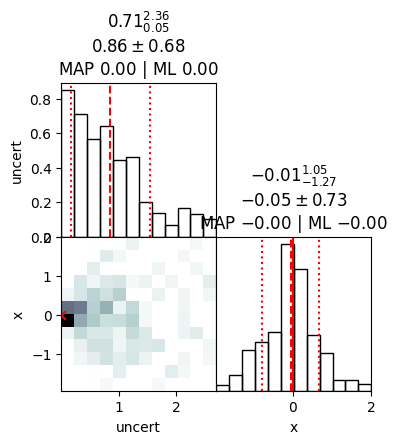

In [6]:
from jaxns import summary, plot_diagnostics, plot_cornerplot

summary(results)
plot_diagnostics(results, save_name='intro_diagnostics.png')
plot_cornerplot(results, save_name='intro_cornerplot.png')

In [7]:
from jaxns import resample

samples = resample(
    key=jax.random.PRNGKey(0),
    samples=results.samples,
    log_weights=results.log_dp_mean,
    S=1000,
    replace=True
)

Convergence achieved at step 3, due to log_Z 0.053926846277900786 < log_Z_ftol * log_Z_uncert 0.10634140636883135.:  60%|████████████████████████████████████████▊                           | 3/5 [00:16<00:11,  5.54s/it]


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 163991
samples: 1935
phantom samples: 0
likelihood evals / sample: 84.7
phantom fraction (%): 0.0%
--------
logZ=-1.23 +- 0.11
max(logL)=14.36
H=-0.79
ESS=149
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 0.7 +- 0.0 | 0.7 / 0.7 / 0.7 | 0.7 | 0.7
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.71 +- 0.79 | 0.12 / 0.44 / 1.63 | 0.0 | 0.0
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: -0.2 +- 2.4 | -2.5 / 0.0 / 1.2 | 0.0 | -0.5
--------


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:196: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(per_1, per_99)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/plotting.py:244: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(param_limits[parameters[col]])


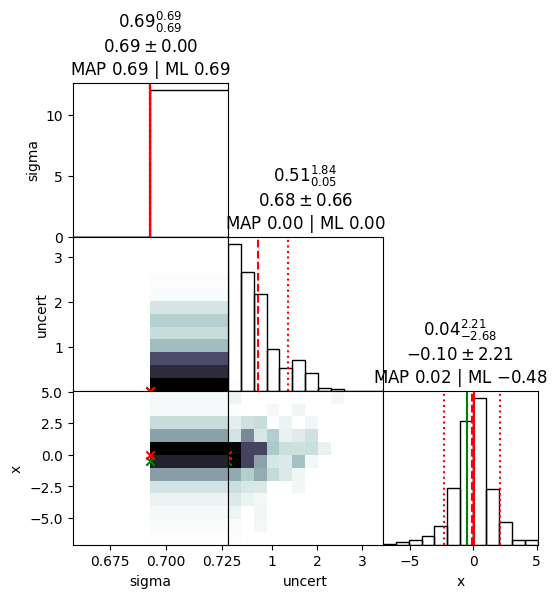

In [8]:
from jaxns.experimental import EvidenceMaximisation

# Let's train the sigma parameter to maximise the evidence

em = EvidenceMaximisation(model)
results, params = em.train(num_steps=5)

summary(results, with_parametrised=True)
plot_cornerplot(results, with_parametrised=True)